<a href="https://colab.research.google.com/github/kongwanbianjinyu/Deep-Learning-Tutorial/blob/main/Initialization_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [8]:
# save dataset
DATASET_PATH = "drive/MyDrive/deep learning tutorial/data"
# save trained model weights
CHECKPOINT_PATH = "drive/MyDrive/deep learning tutorial/saved_models/Initialization"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [60]:
# if not exist, create checkpoint path
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder")

# Preparation

In [10]:
# basic linear network for classifying images(as 1D tensor) to 10 classes
class BaseNetwork(nn.Module):
  def __init__(self,act_func, input_size = 784, num_class = 10, hidden_sizes = [512, 256, 256, 128]):
    super().__init__()

    # layers list
    layers = []
    layer_sizes = [input_size] + hidden_sizes
    for i in range(len(layer_sizes) - 1):
      layers += [nn.Linear(layer_sizes[i],layer_sizes[i+1]),act_func]
    layers += [nn.Linear(layer_sizes[-1],num_class)]

    # * unpacks the list into positional arguments, nn.Sequential make them as a single module
    # ** unpacks the dictionary into key-word arguments
    self.layers = nn.Sequential(*layers)

    # save hyperparemeters to a dictionary: config
    self.config = {"activation": act_func.__class__.__name__, "input_size": input_size, "num_class": num_class," hidden_sizes": hidden_sizes}
  
  def forward(self, x):
    x = x.view(x.size(0),-1) # reshape image to 1D tensor
    return self.layers(x)



In [11]:
from torchvision.datasets import FashionMNIST
train_dataset = FashionMNIST(root = DATASET_PATH, train = True, download = True)
data_mean = (train_dataset.data.float()/255.0).mean().item()
data_std = (train_dataset.data.float()/255.0).std().item()
print(data_mean,data_std)

0.2860405743122101 0.3530242443084717


In [12]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# transforms apply on each image
# transforms.ToTensor() change [0,255] -> [0,1] float value: (C,H,W)
# transforms.Normalize() do: (pixel_value - mean) / std,  pixel_value: [0,1], normalize_pixel_value: mean 0, std: 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (data_mean,),std = (data_std,))])

# train dataset, validation dataset
train_dataset = FashionMNIST(root = DATASET_PATH, train = True, transform = transform, download = True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000,10000])

# test dataset
test_set = FashionMNIST(root = DATASET_PATH, train = False, transform = transform, download = True)

# data loader
train_loader = data.DataLoader(train_set, batch_size = 256, shuffle =True, drop_last = False, pin_memory=True)
val_loader = data.DataLoader(val_set, batch_size = 256, shuffle =False, drop_last = False)
test_loader = data.DataLoader(test_set, batch_size = 256, shuffle =False, drop_last = False)

In [13]:
class Identity(nn.Module):
  def __init__(self):
    super().__init__()
    self.config = {"name":self.__class__.__name__}

  def forward(self,x):
    return x

activation_function_dict = {
    "tanh":nn.Tanh,
    "relu":nn.ReLU,
    "identity":Identity}

# Initialization

In [14]:
net = BaseNetwork(act_func=Identity()).to(device)

## Constant initialization

In [15]:
def const_init(net, c = 0):
  for name,param in net.named_parameters():
    param.data.fill_(c)
    print(name)
    print(param.shape)

In [16]:
const_init(net)

layers.0.weight
torch.Size([512, 784])
layers.0.bias
torch.Size([512])
layers.2.weight
torch.Size([256, 512])
layers.2.bias
torch.Size([256])
layers.4.weight
torch.Size([256, 256])
layers.4.bias
torch.Size([256])
layers.6.weight
torch.Size([128, 256])
layers.6.bias
torch.Size([128])
layers.8.weight
torch.Size([10, 128])
layers.8.bias
torch.Size([10])


## Equal Variance Initialization

The linear layer: $y = Wx + b$

*   mean(y) = 0
*   Var(y) = Var(x) variance stable acorss layers

So we get $Var(W) = \frac{1}{d_x}$



In [17]:
def equal_var_init(net):
  for name, param in net.named_parameters():
    if name.endswith(".bias"):
      # initial b(bias) with 0
      param.data.fill_(0) 
    else:
      # initial weight with normal distribution of std 1/input_size
      param.data.normal_(std = 1.0/math.sqrt(param.shape[1])) # notice shape[1]is input size rather shape[0]


In [18]:
equal_var_init(net)

## Xavier Initialization

xavier initialization would balance the variance of gradient and activation neural. It belongs to Equal Variance Initialization and consider stable gradient variance across layers.

In [19]:
def xavier_init(net):
  for name, param in net.named_parameters():
    if name.endswith(".bias"):
      # initial b(bias) with 0
      param.data.fill_(0) 
    else:
      # initial weight with normal distribution of std 1/input_size
      bound = math.sqrt(6)/math.sqrt(param.shape[1] + param.shape[0]) # 
      param.data.uniform_(-bound,bound)


In [20]:
xavier_init(net)

## Kaiming Initialization

In [21]:
# kaiming init for activation function of ReLU
def kaiming_init(net):
  for name, param in net.named_parameters():
    if name.endswith(".bias"):
      # initial b(bias) with 0
      param.data.fill_(0) 
    elif name.startswith("layer.0"):
      param.data.normal_(std = 1.0/math.sqrt(param.shape[1]))
    else:
      # initial weight with normal distribution of std 1/input_size
      param.data.normal_(std = math.sqrt(2)/math.sqrt(param.shape[1])) # notice shape[1]is input size rather shape[0]


In [22]:
relu_net = BaseNetwork(act_func = nn.ReLU()).to(device)
kaiming_init(relu_net)

# Optimization

## Model training

In [23]:
def save_model(model, model_path, model_name):
  config_dict = model.config
  os.makedirs(model_path,exist_ok = True)
  config_file = os.path.join(model_path, model_name + ".config")
  model_file = os.path.join(model_path, model_name + ".tar")
  # save config(hyperparameter) dict to file using json
  with open(config_file, "w") as f:
    json.dump(config_dict, f)
  # save model parameters(model.state_dict()) to file using torch.save()
  torch.save(model.state_dict(),model_file)


In [24]:
def load_model(model_path, model_name, net = None):
  config_file = os.path.join(model_path, model_name + ".config")
  model_file = os.path.join(model_path, model_name + ".tar")

  # load config(hyperparameter) from file using json
  with open(config_file, "r") as f:
    config_dict = json.load(f)
  
  
  if net is None:
    act_func_name = config_dict["activation"].pop("name").lower() # get activation function name
    act_func = activation_function_dict[act_func_name]()
    net = BaseNetwork(act_func = act_func, **config_dict)

  # load parameters(state_dict) from file using torch.load()
  # net.load_state_dict() can use state_dict() as initial parameter
  net.load_state_dict(torch.load(model_file, map_location = device))

  return net

In [55]:
def train_model(net, model_name, optim_func, train_loader, val_loader, test_loader, epoch_num = 50, overwrite = False):
  is_file_exist = os.path.isfile(os.path.join(CHECKPOINT_PATH, model_name + ".tar"))
  if (is_file_exist and not overwrite):
    print("Model exist, skipping training.")
    # load results
    result_file = os.path.join(CHECKPOINT_PATH,model_name + "_results.json")
    with open(result_file,"r") as f:
      results = json.load(f)
  else:
    if is_file_exist:
      print("Model exist, overwriting model, start training...")
      results = None

    # optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
    optimizer = optim_func(net.parameters())
    loss_func = nn.CrossEntropyLoss()

    # collect result
    val_acc_list = []
    train_acc_list = []
    train_loss_list = []
    best_epoch = -1
    for epoch in range(epoch_num):
      net.train()

      ########## Train ##########
      true_preds_num, all_preds_num = 0, 0
      train_loss = 0
      for X, y in tqdm(train_loader, desc = f"Epoch {epoch + 1} : " ,leave = False):
        # X is image (N,1,H,W), y is label (N,)
        X = X.to(device)
        y = y.to(device)

        # forward and losss
        preds = net(X) # preds is (N,10)
        loss = loss_func(preds,y)

        # backward and updata parameter
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # statistics during training
        true_preds_num += (preds.argmax(dim = -1) == y).sum().item()
        all_preds_num += y.shape[0]
        train_loss += loss.item()
      # train accuracy
      train_acc = true_preds_num / all_preds_num
      train_loss /= len(train_loader)

      train_acc_list.append(train_acc)
      train_loss_list.append(train_loss)

      ######## Validation ############

      # validate accuracy
      val_acc = eval_model(net, val_loader)
      val_acc_list.append(val_acc)
      print(f"[Epoch {epoch +1 : 2d}]: Train Accuarcy: {train_acc*100:5.2f}%, Validation Accuracy:{val_acc*100:5.2f}%")
    
      # save the model with the best validate accuracy
      if(len(val_acc_list) == 1 or (val_acc > val_acc_list[best_val_acc_epoch])):
        print("New best model accuracy, saving model...")

        save_model(net, CHECKPOINT_PATH, model_name)
        best_val_acc_epoch = epoch
      
  ############ Test ##########
  # load model, get test result, save result to result json file
  if results is None:
    load_model(CHECKPOINT_PATH,model_name, net = net)
    test_acc = eval_model(net,test_loader)
    results = {"test_acc":test_acc, "val_scores":val_acc_list,"train_scores": train_acc_list,"train_losses":train_loss_list}
    result_file = os.path.join(CHECKPOINT_PATH,model_name + "_results.json")
    with open(result_file,"w") as f:
      json.dump(results,f)
  # plot
  plot_result(model_name, results)

  print((f"Test Accuracy:{results['test_acc']*100:5.2f}%").center(50, "=") + "\n")
  return results


In [42]:
def eval_model(net, data_loader):
  net.eval()

  true_preds_num, all_preds_num = 0, 0
  for X,y in data_loader:
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
      preds = net(X)
      true_preds_num += (preds.argmax(dim = -1) == y).sum().item()
      all_preds_num += y.shape[0]
  test_acc = true_preds_num / all_preds_num
  return test_acc

In [43]:
def plot_result(model_name,results):
  sns.set()
  plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
  plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
  plt.xlabel("Epochs")
  plt.ylabel("Validation accuracy")
  plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
  plt.title(f"Validation performance of {model_name}")
  plt.legend()
  plt.show()
  plt.close()

Model exist, skipping training.


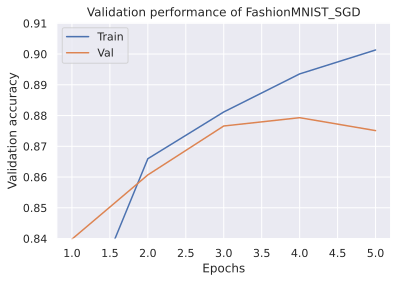

===============Test Accuracy:86.65%===============



In [59]:
base_model = BaseNetwork(act_func=nn.ReLU()).to(device)
kaiming_init(base_model)
SGD_results = train_model(net = base_model, model_name = "FashionMNIST_SGD", optim_func = lambda params: SGD(params, lr = 0.01),
                          train_loader = train_loader, val_loader = val_loader, test_loader = test_loader)
    

Model exist, overwriting model, start training...


Epoch 1 :   0%|          | 0/196 [00:00<?, ?it/s]

[Epoch  1]: Train Accuarcy: 75.40%, Validation Accuracy:79.67%
New best model accuracy, saving model...


Epoch 2 :   0%|          | 0/196 [00:00<?, ?it/s]

[Epoch  2]: Train Accuarcy: 82.66%, Validation Accuracy:82.51%
New best model accuracy, saving model...


Epoch 3 :   0%|          | 0/196 [00:00<?, ?it/s]

[Epoch  3]: Train Accuarcy: 84.33%, Validation Accuracy:83.09%
New best model accuracy, saving model...


Epoch 4 :   0%|          | 0/196 [00:00<?, ?it/s]

[Epoch  4]: Train Accuarcy: 85.47%, Validation Accuracy:84.87%
New best model accuracy, saving model...


Epoch 5 :   0%|          | 0/196 [00:00<?, ?it/s]

[Epoch  5]: Train Accuarcy: 86.13%, Validation Accuracy:84.13%


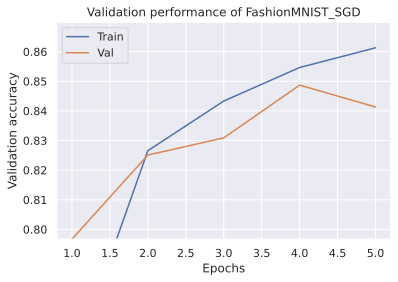

===============Test Accuracy:84.35%===============



In [61]:
# training the model for 5 epoche by ourself
base_model = BaseNetwork(act_func=nn.ReLU()).to(device)
kaiming_init(base_model)
SGD_results = train_model(net = base_model, model_name = "FashionMNIST_SGD",optim_func = lambda params: SGD(params, lr = 0.01),
                          train_loader = train_loader, val_loader = val_loader, test_loader = test_loader, epoch_num = 5, overwrite=True)

## Optimizer

In [52]:
class BaseOptimizer:
  def __init__(self, params, lr):
    self.params = list(params)
    self.lr = lr
  def zero_grad(self):
    for p in self.params:
      if p.grad is not None:
        p.grad.detach_()
        p.grad.zero_()
  @torch.no_grad()
  def step(self):
      ## Apply update step to all parameters
      for p in self.params:
          if p.grad is None: # We skip parameters without any gradients
              continue
          self.update_param(p)

  def update_param(self, p):
      # To be implemented in optimizer-specific classes
      raise NotImplementedError
      

In [53]:
class SGD(BaseOptimizer):
  def __init__(self, params, lr):
    super().__init__(params ,lr)
  
  def update_param(self, p):
    p_new = -self.lr * p.grad
    p.add_(p_new) # in-place update, save memory